In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
###### Constants ######
BATCH_SIZE=64
N_EPOCHS=5
PERCENT_VAL=0.2 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 100
INPUT_SHAPE = (28, 28, 1)

In [4]:
###### Function Definitions ######
def normalize(images, labels):
    # Add channel
    images = tf.expand_dims(images, -1)
    images = tf.cast(images, tf.float32)
    images /= 255
    
    # Add channel
    labels = tf.expand_dims(labels, -1)
    labels = tf.cast(labels, tf.float32)
    labels /= 255
    
    return images, labels

def display_image(image):
    image = image.numpy().reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def display_images(images):
    plt.figure(figsize=(20,20))

    i = 0
    for image in images:
        image = image.numpy().reshape((28,28))
        plt.subplot(np.ceil(len(images)/5),5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def split_data(data, percent):
    n = data.shape[0]
    indices = np.random.permutation(n)
    
    split = int(np.ceil(n * percent))
    return data[indices[split:]], data[indices[:split]]

In [5]:
# 2nd elements are labels, which we don't need
(xtrain, _), (xtest, _) = tf.keras.datasets.fashion_mnist.load_data()

xtest, xval = split_data(xtest, PERCENT_VAL)

n_training = xtrain.shape[0]
n_test = xtest.shape[0]
n_val = xval.shape[0]

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain)).map(normalize).repeat().shuffle(n_training//10).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest)).map(normalize).repeat().batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((xval, xval)).map(normalize).repeat().batch(BATCH_SIZE)

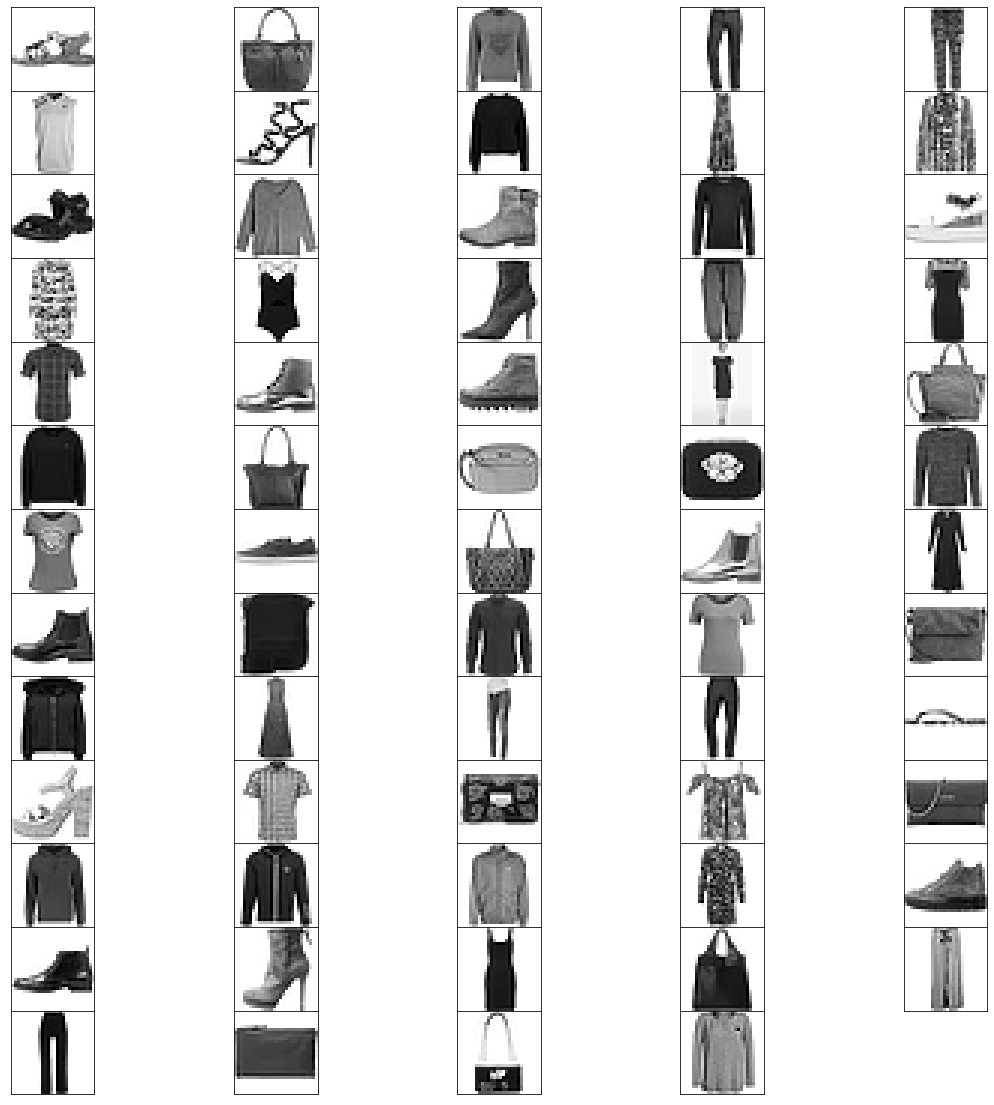

In [7]:
images, labels = next(iter(val_ds))
display_images(images)

In [8]:
# A Convolutional Auto-Encoder
class ConvAutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim, input_shape):
        super(ConvAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(name='encoder',
            layers = [
              tf.keras.layers.InputLayer(input_shape=(28,28,1), name='encoder/input'),
              tf.keras.layers.Conv2D(
                  filters=32, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv1'),
              tf.keras.layers.Conv2D(
                  filters=64, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv2'),
              tf.keras.layers.Flatten(name='encoder/flatten'),
              tf.keras.layers.Dense(latent_dim, name='encoder/bottleneck'),]
        )
        
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(latent_dim), name='decoder/input'),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu, name='decoder/dense1'),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32), name='decoder/reshape'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv1'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv2'),
          tf.keras.layers.Conv2DTranspose(
              filters=1, 
              kernel_size=3, 
              strides=(1, 1),
              activation='sigmoid',
              padding='same', 
              name='decoder/deconv3'),])

    def call(self, inputs):
        z = self.encoder(inputs)
        x = self.decoder(z)
        return x
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [9]:
model = ConvAutoEncoder(latent_dim=LATENT_DIM, input_shape=images.shape[1:])

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [16]:
zs = model.encoder(next(iter(val_ds)))
xs = model.decoder(zs)

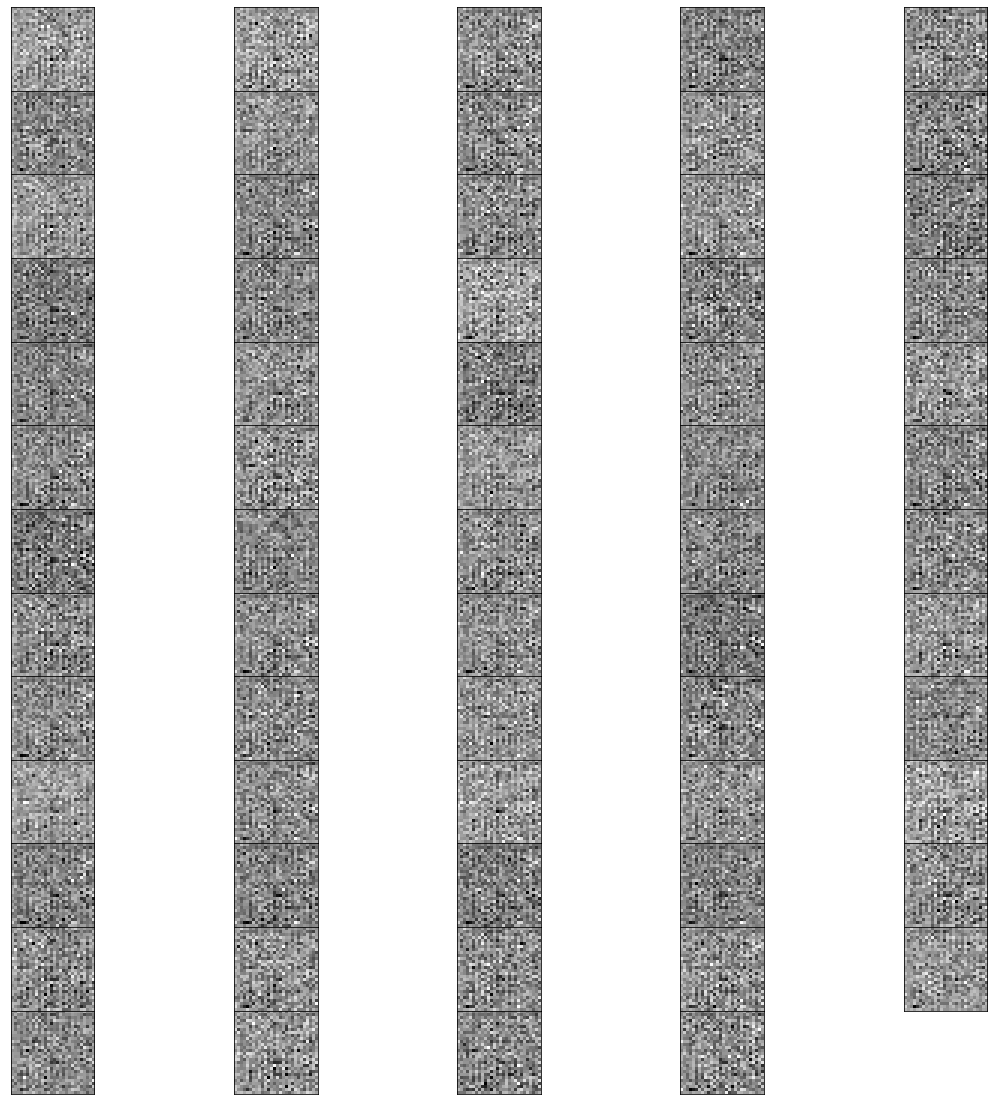

In [17]:
display_images(xs)

In [18]:
# model.fit(train_ds, epochs=N_EPOCHS, steps_per_epoch=np.ceil(n_training/BATCH_SIZE))
model.fit(train_ds, 
          epochs=N_EPOCHS, 
          steps_per_epoch=np.ceil(n_training/BATCH_SIZE), 
          validation_data=val_ds, 
          validation_steps=np.ceil(n_val/BATCH_SIZE))

Train for 938.0 steps, validate for 32.0 steps
938/938 [==============================] - 87s 93ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0097 - val_mean_squared_error: 0.0097


In [19]:
zs = model.encoder(next(iter(val_ds)))
xs = model.decoder(zs)

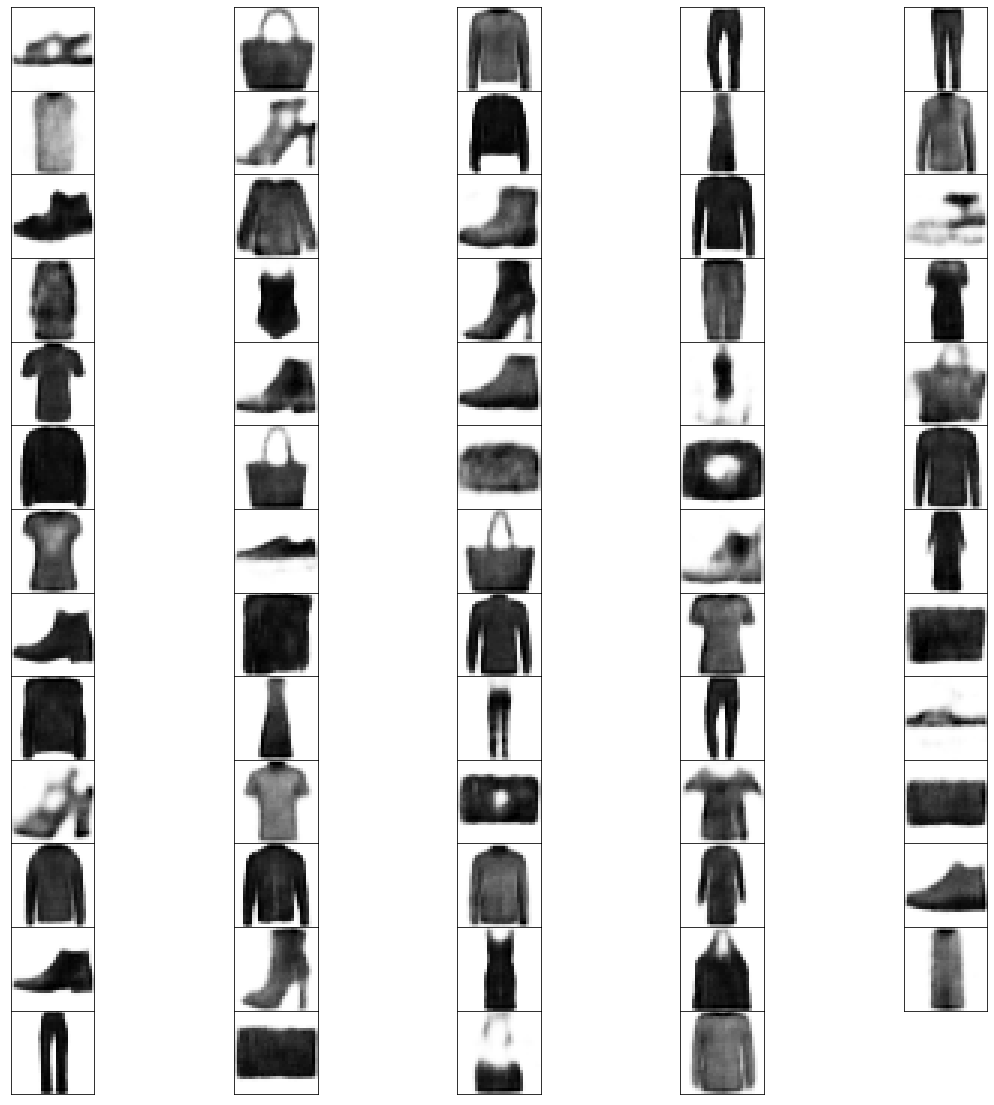

In [20]:
display_images(xs)